In [1]:
import numpy as np
import pandas as pd

import math
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline
import matplotlib.pyplot as plt

os.chdir(r'...')

pd.options.mode.chained_assignment = None  # default='warn'

from tqdm import tnrange, tqdm_notebook

RADIUS = 0.02

In [3]:
# Честное вычисление расстояния по координатам точек
# http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = list(map(math.radians, [lon1, lat1, lon2, lat2]))
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

In [4]:
# Честное вычисление работает очень долго, потому что в нем много тригонометрических функций
# Напишем более быструю функцию для нахождения маленьких расстояний (в этом случае поверхность Земли можно
# рассматривать как плоскость)

# длина в метрах одной сотой градуса по широте
LAT_001_DIST = haversine(0, 0, 0.01, 0)
# длина в метрах одной сотой градуса по долготе для каждой широты с шагом 0.01
LON_001_DIST = [haversine(i / 100.0, 0, i / 100.0, 0.01) for i in range(7500)]

def haversine_fast_sq(lat1, lon1, lat2, lon2):
    y = (lat1 - lat2) * LAT_001_DIST * 100
    key = int(100.0 * lat1)
    x = (lon1 - lon2) * LON_001_DIST[key] * 100
    return x * x + y * y

def haversine_fast(lat1, lon1, lat2, lon2):
    return math.sqrt(haversine_fast_sq(lat1, lon1, lat2, lon2))

# Переводит latlon координаты в x, y относительно origin
# Предполагается, что latlons находятся в первой четверти относительно origin и расстояния не очень
# большие, то есть поверхность можно рассматривать как плоскость 
def latlon_to_xy(latlons, origin):
    olat, olon = origin
    return [(haversine_fast(lat, lon, lat, olon), haversine_fast(lat, lon, olat, lon)) for lat, lon in latlons]

# Переводит x, y координаты в latlon относительно origin
def xy_to_latlon(xy, origin):
    olat, olon = origin
    lon = olon + xy[0] / (LON_001_DIST[int(100.0 * olat)] * 100)
    lat = olat + xy[1] / (LAT_001_DIST * 100)
    return lat, lon

In [6]:
data = {'tra': pd.read_csv('train_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'tes': pd.read_csv('test_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'sub': pd.read_csv('sample.csv')       }

data['tra'] = data['tra'].rename(columns={'pos_adress_lat':'pos_address_lat', 'pos_adress_lon':'pos_address_lon'})

In [7]:
"""убираем транзакции без координат (initial train)"""

data['tra']['address_lat'] = data['tra']['pos_address_lat'].fillna(data['tra']['atm_address_lat'])
data['tra']['address_lon'] = data['tra']['pos_address_lon'].fillna(data['tra']['atm_address_lon'])

data['tra'] = data['tra'][data['tra']['address_lat'].isnull()==0]

data['tra']['gps'] = data['tra']['address_lat'].apply(str) + ', ' + data['tra']['address_lon'].apply(str)

In [8]:
"""убираем транзакции без координат (initial test)"""

data['tes']['address_lat'] = data['tes']['pos_address_lat'].fillna(data['tes']['atm_address_lat'])
data['tes']['address_lon'] = data['tes']['pos_address_lon'].fillna(data['tes']['atm_address_lon'])

data['tes'] = data['tes'][data['tes']['address_lat'].isnull()==0]

data['tes']['gps'] = data['tes']['address_lat'].apply(str) + ', ' + data['tes']['address_lon'].apply(str)

In [9]:
len(data['tra']), len(data['tes'])

(1127294, 1166971)

In [10]:
"""находим ID с задвоением дома и работы"""

data['tra']['home_add'] = data['tra'].home_add_lat + ', ' + data['tra'].home_add_lon
data['tra']['work_add'] = data['tra'].work_add_lat + ', ' + data['tra'].work_add_lon

unique_home_add = data['tra'][['customer_id','home_add']].groupby('customer_id')['home_add'].nunique()
unique_work_add = data['tra'][['customer_id','work_add']].groupby('customer_id')['work_add'].nunique()

print("Кол-во координат уникальных домов: {}".format(data['tra']['home_add'].nunique()), 
      "Кол-во координат уникального места работы: {}".format(data['tra']['work_add'].nunique()))
print("Кол-во id с 1 домом: {}".format(len(unique_home_add[unique_home_add == 1])), 
      "Кол-во id с 1 работой: {}".format(len(unique_work_add[unique_work_add == 1])))

Кол-во координат уникальных домов: 10146 Кол-во координат уникального места работы: 4584
Кол-во id с 1 домом: 9664 Кол-во id с 1 работой: 5110


In [11]:
"""ID с задвоением"""
double_home_ids = list(unique_home_add[unique_home_add == 2].index)
double_work_ids = list(unique_home_add[unique_work_add == 2].index)

In [12]:
"""DOUUBLE HOME"""
"""задвоение с домом можно взять для трейна работы и наоборот (но можно попробовать взять всё)
    берем максимальное кол-во транзакций для ID-адрес"""

double_home_df = data['tra'][data['tra']['customer_id'].isin(double_home_ids) == 1].groupby(
    ['customer_id', 'home_add'])['amount'].count().reset_index()

double_home_df_keys = double_home_df.groupby('customer_id').max().reset_index()
double_home_df = pd.merge(double_home_df, double_home_df_keys, on=['customer_id', 'home_add'], how='left')
double_home_df['amount_y'] = double_home_df['amount_y'].fillna('del')
data['tra'] = pd.merge(data['tra'], double_home_df[['customer_id', 'home_add', 'amount_y']], 
                       on=['customer_id', 'home_add'], how='left')

data['tra'].drop(data['tra'][data['tra']['amount_y'] == 'del'].index, inplace=True)
data['tra'].drop('amount_y', axis=1, inplace=True)

In [13]:
"""DOUBLE WORK"""
"""задвоение с домом можно взять для трейна работы и наоборот (но можно попробовать взять всё)
    берем максимальное кол-во транзакций для ID-адрес"""

double_work_df = data['tra'][data['tra']['customer_id'].isin(double_work_ids) == 1].groupby(
    ['customer_id', 'work_add'])['amount'].count().reset_index()

double_work_df_keys = double_work_df.groupby('customer_id').max().reset_index()
double_work_df = pd.merge(double_work_df, double_work_df_keys, on=['customer_id', 'work_add'], how='left')
double_work_df['amount_y'] = double_work_df['amount_y'].fillna('del')
data['tra'] = pd.merge(data['tra'], double_work_df[['customer_id', 'work_add', 'amount_y']], 
                       on=['customer_id', 'work_add'], how='left')

data['tra'].drop(data['tra'][data['tra']['amount_y'] == 'del'].index, inplace=True)
data['tra'].drop('amount_y', axis=1, inplace=True)

In [14]:
"""убираем строки гр-на с nan в графе место жительства (1a7ea74837f017610970ae508dcd0c26)"""
data['tra'] = data['tra'][data['tra'].home_add_lat.isnull() == 0]

In [15]:
len(data['tra']), len(data['tes'])

(1085224, 1166971)

In [16]:
"""берем все ID, проверям модель на улучшение, создаем датасет для обучения"""
train_ids = list(data['tra']['customer_id'].unique())
train_ids = pd.DataFrame(train_ids, columns=['customer_id'])
train_ids['train_ids'] = 1
train_df = data['tra'].copy()

print("Кол-во train ID: {}".format(data['tra']['customer_id'].nunique()),
      "Кол-во координат уникальных домов: {}".format(data['tra']['home_add'].nunique()), 
      "Кол-во координат уникального места работы: {}".format(data['tra']['work_add'].nunique()))

Кол-во train ID: 10000 Кол-во координат уникальных домов: 9839 Кол-во координат уникального места работы: 4546


In [17]:
"""переводим координаты во float"""
train_df.work_add_lat = train_df.work_add_lat.astype(float)
train_df.work_add_lon = train_df.work_add_lon.astype(float)
train_df.home_add_lat = train_df.home_add_lat.astype(float)
train_df.home_add_lon = train_df.home_add_lon.astype(float)

train_df.address_lat = train_df.address_lat.astype(float)
train_df.address_lon = train_df.address_lon.astype(float)

In [18]:
"""создаем Y  (опционально: убираем ID, рядом с домами/работой которых было мало транзакций)"""

train_df['nearby_home'] = ((train_df['address_lat'] + RADIUS >= train_df['home_add_lat']) & 
                     (train_df['address_lat'] - RADIUS <= train_df['home_add_lat']) &
                     (train_df['address_lon'] + RADIUS >= train_df['home_add_lon']) & 
                     (train_df['address_lon'] - RADIUS <= train_df['home_add_lon'])).astype(int)

train_df['nearby_work'] = ((train_df['address_lat'] + RADIUS >= train_df['work_add_lat']) & 
                     (train_df['address_lat'] - RADIUS <= train_df['work_add_lat']) &
                     (train_df['address_lon'] + RADIUS >= train_df['work_add_lon']) & 
                     (train_df['address_lon'] - RADIUS <= train_df['work_add_lon'])).astype(int)

In [19]:
train_df['nearby_home'].sum() / len(train_df['nearby_home'])

0.24964431306347815

In [ ]:
"""этот блок опускаем, т.е. расчитываем на полной выборке"""

In [20]:
tr_qty_by_ids = pd.DataFrame(train_df.groupby('customer_id')['nearby_home'].count()).reset_index()
tr_qty_by_ids_home = pd.DataFrame(train_df.groupby('customer_id')['nearby_home'].sum()).reset_index()
tr_qty_by_ids_home = pd.merge(tr_qty_by_ids_home, tr_qty_by_ids, on='customer_id', how='left')
tr_qty_by_ids_home['frq'] = tr_qty_by_ids_home['nearby_home_x'] / tr_qty_by_ids_home['nearby_home_y']

In [24]:
"выбрасываем в конце"
len(tr_qty_by_ids_home[tr_qty_by_ids_home['nearby_home_x'] == 0])

2350

In [ ]:
#tr_qty_by_ids_work[tr_qty_by_ids_work['frq'] > 0.05]['frq'].plot.hist();   #histogram
#tr_qty_by_ids_work_outl = tr_qty_by_ids_work[tr_qty_by_ids_work['frq'] <= 0.05]
#train_df = pd.merge(train_df, tr_qty_by_ids_work_outl[['customer_id', 'frq']], on=['customer_id'], how='left')
#train_df = train_df[train_df.frq.isnull()==1]
#train_df.drop('frq', axis=1, inplace=True)

In [25]:
"""добавляем стоблец 'тип транзакции' в трейн и тест, исправляем ошибку в кодах категории покупок в тесте """
train_df['tr_type'] = np.where(train_df['pos_address_lat'].isnull(), 0, 1)   #atm = 0, pos = 1

test_df = data['tes'].copy()
test_df['tr_type'] = np.where(test_df['pos_address_lat'].isnull(), 0, 1)   #atm = 0, pos = 1
test_df['mcc'] = test_df['mcc'].map(lambda x: str(x).replace(',', ''))

In [26]:
"""убираем ненужные столбцы: atm_address, atm_address_lat, atm_address_lon, 
    city, country, pos_address, pos_address_lat, pos_address_lon """

train_df = train_df.drop(['atm_address', 'atm_address_lat', 'atm_address_lon', 'city', 
                   'country', 'pos_address', 'pos_address_lat', 'pos_address_lon'], axis=1)
test_df = test_df.drop(['atm_address', 'atm_address_lat', 'atm_address_lon', 'city', 
                   'country', 'pos_address', 'pos_address_lat', 'pos_address_lon'], axis=1)

In [ ]:
"""объединяем выборки: запоминаем id для востановления"""
"""добавить: обратный гекодинг (подтянуть информацию)"""
"""анализируем получившиеся результаты после объединения"""
"""раставляем одинаковые лейблы в трейне и тесте"""

In [27]:
"""объединяем выборки"""
inf_about_h_and_w_columns = ['home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon', 'home_add', 'work_add']
train_and_test_together = pd.concat([train_df.drop(inf_about_h_and_w_columns, axis=1), test_df])

"""запоминаем id для востановления"""
test_customer_ids = pd.DataFrame(test_df.customer_id.unique(), columns=['customer_id'])
test_customer_ids['test_sample'] = 1

#train_customer_ids_w_address = train_df[['customer_id','home_add_lat','home_add_lon', 
#                                      'work_add_lat', 'work_add_lon']].drop_duplicates()

train_and_test_together = pd.merge(train_and_test_together, test_customer_ids, on='customer_id', how='left')

In [28]:
len(train_and_test_together)

2252195

In [ ]:
"""!!!!! добавить: обратный гекодинг (подтянуть информацию): два варианта
    1) online: 50% загружено - вернуться позже,
    2) offline: используем """

In [ ]:
reverse_geocoding_first = pd.read_excel(r'reverse geocoding\xlsx\2018_02_18_reverse_geocoding_train_pos.xlsx')
reverse_geocoding_second = pd.read_excel(r'reverse geocoding\xlsx\2018_02_21_rg_third_calc_45520.xlsx')

In [ ]:
print("Первый файл (кол-во координат): {0}, Второй файл: {1} ".format(len(reverse_geocoding_first), 
                                                                      len(reverse_geocoding_second)))
print("Общее количество уникальных координат: {}".format(len(pd.Series(list(reverse_geocoding_first.gps.unique()) + 
                                                                       list(reverse_geocoding_second.gps.unique())).unique())))

In [ ]:
pd.merge(train_and_test_together, reverse_geocoding[['state','pos_lat_lon', 'country']], on=['gps'], how='left')

In [29]:
"""offline подход (быстрый): https://github.com/thampiman/reverse-geocoder """
import reverse_geocoder as rg

train_and_test_together.address_lat = train_and_test_together.address_lat.apply(float)
train_and_test_together.address_lon = train_and_test_together.address_lon.apply(float)

latlon_subset = train_and_test_together[['address_lat', 'address_lon']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]

reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

train_and_test_together['country'] = reverse_geo_df['cc'].values
train_and_test_together['region'] = reverse_geo_df['admin1'].values
train_and_test_together['place'] = reverse_geo_df['name'].values

len(train_and_test_together)

Loading formatted geocoded file...


2252195

In [30]:
"""убираем все страны, кроме RU, UA"""
train_and_test_together = train_and_test_together[(train_and_test_together.country == 'RU') |
                                                  (train_and_test_together.country == 'UA')]

In [ ]:
"""убирать ничего не будем, берем максимум"""

In [ ]:
"""ПРОВЕРИТЬ, сколько Y TRUE мы выкидываем !!! """

In [31]:
"""PLACES: убираем места, которые встречаются 1 раз"""
places_to_drop = list(train_and_test_together.place.value_counts()[train_and_test_together.place.value_counts() <= 1].index)
train_and_test_together = train_and_test_together[train_and_test_together.place.isin(places_to_drop) == False]

In [32]:
"""REGIONS: убираем регионы с частотой ниже порога для каждого ID"""
tr_qty_by_ids = pd.DataFrame(train_and_test_together.groupby(['customer_id'])['amount'].count()).reset_index()
tr_qty_by_ids_region = pd.DataFrame(train_and_test_together.groupby(['customer_id', 'region'])['country'].count()).reset_index()
tr_qty_by_ids_region = pd.merge(tr_qty_by_ids_region, tr_qty_by_ids, on=['customer_id'], how='left')
tr_qty_by_ids_region['frq_rg'] = tr_qty_by_ids_region['country'] / tr_qty_by_ids_region['amount']

tr_region_outl = tr_qty_by_ids_region[tr_qty_by_ids_region['frq_rg'] <= 0.20]
train_and_test_together = pd.merge(train_and_test_together, 
                                   tr_region_outl[['customer_id', 'region', 'frq_rg']], 
                                   on=['customer_id', 'region'], how='left')
train_and_test_together[train_and_test_together.test_sample==1]['customer_id'].nunique()

9997

In [ ]:
"""убираем транзакции с частотой ниже порога"""
#tr_qty_by_ids_region[tr_qty_by_ids_region['frq_rg'] > 0.2]['frq_rg'].plot.hist();

In [33]:
"""PLACES: убираем места с частотой ниже порога для каждого ID"""
#train_and_test_together = train_and_test_together[train_and_test_together.frq_rg.isnull()==1]
tr_qty_by_ids = pd.DataFrame(train_and_test_together.groupby(['customer_id'])['amount'].count()).reset_index()
tr_qty_by_ids_place = pd.DataFrame(train_and_test_together.groupby(['customer_id', 'place'])['amount'].count()).reset_index()
tr_qty_by_ids_place = pd.merge(tr_qty_by_ids_place, tr_qty_by_ids, on=['customer_id'], how='left')
tr_qty_by_ids_place['frq_pl'] = tr_qty_by_ids_place['amount_x'] / tr_qty_by_ids_place['amount_y']

tr_place_outl = tr_qty_by_ids_place[tr_qty_by_ids_place['frq_pl'] <= 0.07]
train_and_test_together = pd.merge(train_and_test_together, 
                                   tr_place_outl[['customer_id', 'place', 'frq_pl']], on=['customer_id', 'place'], how='left')
train_and_test_together = train_and_test_together[train_and_test_together.frq_pl.isnull()==1]
train_and_test_together = train_and_test_together.drop(train_and_test_together.columns[-2:], axis=1)
train_and_test_together[train_and_test_together.test_sample==1]['customer_id'].nunique()

9997

In [ ]:
"""убираем транзакции с частотой ниже порога (7%, чтобы попал весть тест)"""
#tr_qty_by_ids_place[tr_qty_by_ids_place['frq_pl'] > 0.07]['frq_pl'].plot.hist();

In [34]:
"""добавляем столбецы с частотой города, места"""
train_and_test_together = pd.merge(train_and_test_together, tr_qty_by_ids_region[['customer_id', 'region', 'frq_rg']], 
                                   on=['customer_id', 'region'], how='left')
train_and_test_together = pd.merge(train_and_test_together, tr_qty_by_ids_place[['customer_id', 'place', 'frq_pl']], 
                                   on=['customer_id', 'place'], how='left')

In [ ]:
"""убираем значения amount <= 0"""
#train_and_test_together = train_and_test_together[train_and_test_together.amount > 0]

In [35]:
"""AMOUNT"""
train_and_test_together.loc[:,'amount'] = np.array(train_and_test_together['amount'].apply(float))

"""создаем переменные с amount / попробуем убрать все варианты с exp оставим только 10 ** """
train_and_test_together['am_e'] = np.exp(train_and_test_together.amount)
train_and_test_together['am_10'] = 10 ** (train_and_test_together.amount)

amount_by_id = train_and_test_together.groupby('customer_id').agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]}).reset_index()

amount_by_id.columns = amount_by_id.columns.droplevel()
amount_by_id = amount_by_id.add_prefix('am_10_')
amount_by_id = amount_by_id.rename(columns={"am_10_":"customer_id"})

In [36]:
train_and_test_together = pd.merge(train_and_test_together, amount_by_id, on='customer_id', how='left')

In [37]:
"""создаем переменные, учитывающие время"""
train_and_test_together['transaction_date'] = pd.to_datetime(train_and_test_together['transaction_date'])

train_and_test_together['month'] = train_and_test_together['transaction_date'].dt.month
train_and_test_together['week'] = train_and_test_together['transaction_date'].dt.week
train_and_test_together['day'] = train_and_test_together['transaction_date'].dt.day
train_and_test_together['dow'] = train_and_test_together['transaction_date'].dt.weekday
train_and_test_together['winm'] = (train_and_test_together.transaction_date.dt.day - 1) // 7 + 1
train_and_test_together['is_wkend'] = np.where((train_and_test_together['dow'] == 5) | 
                                               (train_and_test_together['dow'] == 6), 1, 0)

"""праздники"""

train_and_test_together['23feb'] = np.where(train_and_test_together['transaction_date'] == '2017-02-23', 1, 0) #24.02 - нерабочий
train_and_test_together['8mar'] = np.where(train_and_test_together['transaction_date'] == '2017-03-08', 1, 0)
train_and_test_together['1may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-01', 1, 0)
train_and_test_together['9may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-09', 1, 0) #08.05 - нерабочий
train_and_test_together['12jun'] = np.where(train_and_test_together['transaction_date'] == '2017-06-12', 1, 0)
train_and_test_together['4nov'] = np.where(train_and_test_together['transaction_date'] == '2017-11-06', 1, 0) #04.11 - суббота

"""нерабочие дни"""

train_and_test_together['24feb'] = np.where(train_and_test_together['transaction_date'] == '2017-02-24', 1, 0)
train_and_test_together['8may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-08', 1, 0)

In [38]:
"""кол-во транзакций в день"""
tr_by_ids_time_df = train_and_test_together.groupby(['customer_id', 'transaction_date'])['amount'].count().reset_index()
tr_by_ids_time_df['time_diff'] = tr_by_ids_time_df.groupby('customer_id')['transaction_date'].diff().fillna(0)
tr_by_ids_time_df.time_diff = tr_by_ids_time_df.time_diff.dt.days
tr_by_ids_time_df = tr_by_ids_time_df.rename(columns={'amount':'tr_qty_time'})

In [39]:
train_and_test_together = pd.merge(train_and_test_together, tr_by_ids_time_df, 
                                on=['customer_id', 'transaction_date'], how='left')
len(train_and_test_together)

1775385

In [40]:
"""добавляем частоту дат по регионам"""
tr_by_ids_time_reg = train_and_test_together.groupby(['customer_id', 'region'])['transaction_date'].count().reset_index()
tr_by_ids_time_reg  = tr_by_ids_time_reg.merge(train_and_test_together.groupby(
    ['customer_id', 'region'])['transaction_date'].nunique().reset_index(), on=['customer_id', 'region'], how='left')
tr_by_ids_time_reg['frq_date'] = tr_by_ids_time_reg['transaction_date_x'] / tr_by_ids_time_reg['transaction_date_y']
tr_by_ids_time_reg.rename(columns={'transaction_date_x':'date_reg_count', 'transaction_date_y':'date_reg_uni'}, inplace=True)

In [41]:
train_and_test_together = pd.merge(train_and_test_together, tr_by_ids_time_reg, on=['customer_id', 'region'], how='left')

In [42]:
len(train_and_test_together.columns)

47

In [ ]:
"""в настоящей версии пропускаем блок с самым частым регионом (спорный момент), 
основная проблема: живет и работает в разных регионах (МСК - МО)"""

In [43]:
"""убираем валюту ОАЭ"""
train_and_test_together = train_and_test_together[train_and_test_together.currency != "784.0"]

In [44]:
"""создаем таблицу вида id/unique gps(latlon), считаем количество повторов; 
    оптимизируем следующий этап вычисления накопленного расстояния"""
cust_and_gps_df = pd.DataFrame(train_and_test_together.groupby(
    ['customer_id', 'gps'])['amount'].count()).reset_index().rename(columns={"amount":"id_gps_count"})
cust_and_gps_df['address_lat'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[0]).apply(float)
cust_and_gps_df['address_lon'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[1]).apply(float)

In [45]:
'''добавляем столбец с каунтом повторяющихся координат'''

train_and_test_together = pd.merge(train_and_test_together, cust_and_gps_df[['customer_id', 'gps', 'id_gps_count']], 
                                   on=['customer_id', 'gps'], how='left')

In [ ]:
"""считаем оставшиеся координаты"""

In [46]:
"""загружаем расчёты дистанций для комбинации ID/GPS"""
cum_distance_df01 = pd.read_csv(r'cum distance\cum_distance_df_4673.csv',
                                dtype={'cum_distance_and_count':str})
cum_distance_df02 = pd.read_csv(r'cum distance\cum_distance_df_4673-10183.csv', 
                                dtype={'cum_distance_and_count':str})
cum_distance_df03 = pd.read_csv(r'cum distance\cum_distance_df_other_train.csv')
cum_distance_df04 = pd.read_csv(r'cum distance\cum_distance_df_other_train02.csv')
cum_distance_df05 = pd.read_csv(r'cum distance\cum_distance_df_other_train03.csv')
cum_distance_df06 = pd.read_csv(r'cum distance\cum_distance_df_other_train04.csv')
cum_distance_df07 = pd.read_csv(r'cum distance\cum_distance_df_other_train05_work.csv')
cum_distance_df08 = pd.read_csv(r'cum distance\cum_distance_df_other_train06.csv')

In [47]:
cum_distance_df03 = pd.concat([cum_distance_df03, cum_distance_df04, 
                               cum_distance_df05, cum_distance_df06, cum_distance_df07, cum_distance_df08])
cum_distance_df03 = cum_distance_df03[cum_distance_df03.columns[1:]]

cum_distance = cum_distance_df01.copy()
cum_distance.cum_distance_and_count = cum_distance.cum_distance_and_count.fillna(cum_distance_df02.cum_distance_and_count)
cum_distance = cum_distance[cum_distance.columns[1:]]

cum_distance['cum_neighb_dist'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                          str(x).split(",")[0]).map(lambda
                                                                                                    x: str(x).replace("[", ""))
cum_distance['neighb_count'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                       str(x).split(",")[1]).map(lambda x:
                                                                                                 str(x).replace("]", ""))
cum_distance.drop('cum_distance_and_count', axis=1, inplace=True)
cum_distance = pd.concat([cum_distance, cum_distance_df03])

In [48]:
train_and_test_together = pd.merge(train_and_test_together, 
                                   cum_distance[['customer_id', 'gps', 'cum_neighb_dist', 'neighb_count']],
                                   on=['customer_id', 'gps'], how='left')

In [60]:
"""округляем GPS !!!"""

#cum_and_gps_df_new = test[test.cum_neighb_dist.isnull()==1]
#cum_and_gps_df_new = pd.DataFrame(cum_and_gps_df_new.groupby(['customer_id', 'gps'])['amount'].count()).reset_index()
#cum_and_gps_df_new['address_lat'] = cum_and_gps_df_new.gps.map(lambda x: str(x).split(',')[0]).apply(float)
#cum_and_gps_df_new['address_lon'] = cum_and_gps_df_new.gps.map(lambda x: str(x).split(',')[1]).apply(float)

In [ ]:
%%time
"""считаем дистанцию только для точек, которые попадают в радиус 0.02 градуса"""
cum_distance_list = {}
RADIUS = 0.02

"""берем уникального клиента"""
for cust in tqdm_notebook(list(cum_and_gps_df_new.customer_id.unique())):

    """отсчитываем кол-во шагов (длина массива)"""
    for steps in list(cum_and_gps_df_new[cum_and_gps_df_new.customer_id == cust].index):
        
        distance_value = 0
        lat = cum_and_gps_df_new[cum_and_gps_df_new.customer_id == cust].loc[steps, 'address_lat']
        lon = cum_and_gps_df_new[cum_and_gps_df_new.customer_id == cust].loc[steps, 'address_lon']
        
        df_to_iterate = cum_and_gps_df_new[(cum_and_gps_df_new.customer_id == str(cust)) 
                        & ((lat + RADIUS) >= (cum_and_gps_df_new.address_lat))
                        & ((lat - RADIUS) <= (cum_and_gps_df_new.address_lat))
                        & ((lon + RADIUS) >= (cum_and_gps_df_new.address_lon))
                        & ((lon - RADIUS) <= (cum_and_gps_df_new.address_lon))].copy()
        
        if len(df_to_iterate) == 1:
            cum_distance_list[steps] = [0, 1]
        
        else:
            for tr in list(df_to_iterate.index):
                    
                    x = haversine_fast(lat, 
                                       lon,
                                       df_to_iterate.loc[tr, 'address_lat'],
                                       df_to_iterate.loc[tr, 'address_lon'])
                    
                    distance_value = distance_value + x
                    cum_distance_list[steps] = [distance_value, len(df_to_iterate)]

In [62]:
#cum_and_gps_df_new['cum_neighb_dist'] = pd.DataFrame(cum_distance_list).T[0]
#cum_and_gps_df_new['neighb_count'] = pd.DataFrame(cum_distance_list).T[1]

In [49]:
"""работаем с mcc кодами"""
train_and_test_together['mcc'] = train_and_test_together.mcc.apply(int)

mcc_codes = pd.read_csv('mcc_codes.csv')
mcc_codes.irs_description = [str(i).lower() for i in mcc_codes.irs_description]
mcc_codes.columns

Index(['mcc', 'edited_description', 'combined_description', 'usda_description',
       'irs_description', 'irs_reportable'],
      dtype='object')

In [50]:
"""объединяем похожие категории"""
import re
unique_mcc = list(mcc_codes.irs_description.unique())
regex=re.compile(".*(car).*")
group_list = [m.group(0) for l in unique_mcc for m in [regex.search(l)] if m]

"""лист, содержащий mcc коды автомобильной тематики"""
drivers_list = ['car rental agencies', 'car rental' ,'car washes', 
                'car and truck dealers (new & used) sales, service, repairs parts and leasing ', 
                'car and truck dealers (used only) sales, service, repairs parts and leasing ',
               'service stations']

train_and_test_together = pd.merge(train_and_test_together, mcc_codes[['mcc', 'irs_description']], on='mcc', how='left')
drivers_id = list(train_and_test_together[train_and_test_together.irs_description.isin(drivers_list)]['customer_id'].unique())
drivers_id = pd.Series(drivers_id).rename("customer_id")
drivers_id = pd.DataFrame(drivers_id)
drivers_id['is_dr'] = 1
train_and_test_together['is_dr'] = pd.merge(train_and_test_together, drivers_id, on='customer_id', how='left')['is_dr'].fillna(0)

In [51]:
"""добавляем столбец с частотой mcc"""
tr_qty_by_ids = pd.DataFrame(train_and_test_together.groupby(['customer_id'])['amount'].count()).reset_index()
tr_qty_by_ids_mcc = pd.DataFrame(train_and_test_together.groupby(
    ['customer_id', 'irs_description'])['amount'].count()).reset_index()
tr_qty_by_ids_mcc = pd.merge(tr_qty_by_ids_mcc, tr_qty_by_ids, on=['customer_id'], how='left')
tr_qty_by_ids_mcc['frq_mcc'] = tr_qty_by_ids_mcc['amount_x'] / tr_qty_by_ids_mcc['amount_y']

In [52]:
train_and_test_together = pd.merge(train_and_test_together, tr_qty_by_ids_mcc[['customer_id', 'irs_description', 'frq_mcc']], 
                                   on=['customer_id', 'irs_description'], how='left')

In [ ]:
"""выбираем подход для категориальных переменных: OHE, hashing trick, sparse matrix, pd.get_dummies [25.02]"""

In [53]:
"""формат float"""
train_and_test_together['cum_neighb_dist'] = train_and_test_together['cum_neighb_dist'].astype(float)
train_and_test_together['neighb_count'] = train_and_test_together['neighb_count'].astype(float)

In [54]:
"""AMOUNT / добавляем переменные, связанные с категориями: region, place, irs_description"""
amount_by_region = train_and_test_together.groupby(
    ['region']).agg({'am_10': [np.sum, np.mean, np.median, np.size, np.std, np.var ]}).reset_index()
amount_by_region.columns = amount_by_region.columns.droplevel()
amount_by_region = amount_by_region.add_prefix('amr_')
amount_by_region = amount_by_region.rename(columns={"amr_":"region"})

amount_by_place = train_and_test_together.groupby(
    ['place']).agg({'am_10' : [np.sum, np.mean, np.median, np.size, np.std, np.var ]}).reset_index()
amount_by_place.columns = amount_by_place.columns.droplevel()
amount_by_place = amount_by_place.add_prefix('amp_')
amount_by_place = amount_by_place.rename(columns={"amp_":"place"})

amount_by_mcc = train_and_test_together.groupby(
    ['irs_description']).agg({'am_10' : [np.sum, np.mean, np.median, np.size, np.std, np.var ]}).reset_index()
amount_by_mcc.columns = amount_by_mcc.columns.droplevel()
amount_by_mcc = amount_by_mcc.add_prefix('ammc_')
amount_by_mcc = amount_by_mcc.rename(columns={"ammc_":"irs_description"})

amount_by_dow = train_and_test_together.groupby(
    ['dow']).agg({'am_10' : [np.sum, np.mean, np.median, np.size, np.std, np.var ]}).reset_index()
amount_by_dow.columns = amount_by_dow.columns.droplevel()
amount_by_dow = amount_by_dow.add_prefix('amd_')
amount_by_dow = amount_by_dow.rename(columns={"amd_":"dow"})



train_and_test_together = pd.merge(train_and_test_together, amount_by_region, on='region', how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_by_place, on='place', how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_by_mcc, on='irs_description', how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_by_dow, on='dow', how='left')


In [55]:
"""AMOUNT / добавляем amount id+ region/mcc/dow"""
amount_reg_by_id = train_and_test_together.groupby(['customer_id', 'region']).agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]})

amount_reg_by_id.columns = amount_reg_by_id.add_prefix('am_ireg_').columns.droplevel()
amount_reg_by_id.reset_index(inplace=True)

amount_pl_by_id = train_and_test_together.groupby(['customer_id', 'place']).agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]})

amount_pl_by_id.columns = amount_pl_by_id.add_prefix('am_ipl_').columns.droplevel()
amount_pl_by_id.reset_index(inplace=True)

amount_mcc_by_id = train_and_test_together.groupby(['customer_id', 'irs_description']).agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]})

amount_mcc_by_id.columns = amount_mcc_by_id.add_prefix('am_imcc_').columns.droplevel()
amount_mcc_by_id.reset_index(inplace=True)

amount_dow_by_id = train_and_test_together.groupby(['customer_id', 'dow']).agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]})

amount_dow_by_id.columns = amount_dow_by_id.add_prefix('am_idow_').columns.droplevel()
amount_dow_by_id.reset_index(inplace=True)


In [56]:
%%time
train_and_test_together = pd.merge(train_and_test_together, amount_reg_by_id, on=['customer_id','region'], how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_pl_by_id, on=['customer_id','place'], how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_mcc_by_id, on=['customer_id','irs_description'], how='left')
train_and_test_together = pd.merge(train_and_test_together, amount_dow_by_id, on=['customer_id','dow'], how='left')

Wall time: 8.02 s


In [57]:
del amount_reg_by_id, amount_pl_by_id, amount_mcc_by_id, amount_dow_by_id, amount_by_region, amount_by_place, amount_by_mcc, amount_by_dow

In [58]:
len(train_and_test_together)

1783007

In [59]:
"""убираем ID, рядом с которыми не было транзакций"""
train_and_test_together = train_and_test_together[train_and_test_together.customer_id.isin(
    list(tr_qty_by_ids_home[tr_qty_by_ids_home['nearby_home_x'] == 0]['customer_id'])) == 0]
len(train_and_test_together)

1623202

In [60]:
real_address = pd.DataFrame(train_and_test_together[train_and_test_together.test_sample!=1].customer_id.unique())
real_address.columns = ['customer_id']
real_address = pd.merge(real_address, 
                        data['tra'][['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']],
                        on='customer_id', how='left').drop_duplicates().reset_index(drop=True)
real_address[real_address.columns[1:]] = real_address[real_address.columns[1:]].astype(float)

In [61]:
train_and_test_together = pd.merge(train_and_test_together, real_address, on='customer_id', how='left')

In [62]:
"""HOME / растояние до работы: создаем целевую переменную для моделирования / функция для расчета дистанции ниже"""
y_home_distance = []

for i, row in tqdm_notebook(enumerate(train_and_test_together[train_and_test_together.test_sample!=1][
    ['home_add_lat', 'home_add_lon', 'address_lat', 'address_lon']].itertuples())):
    y_home_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [63]:
train_and_test_together.loc[train_and_test_together[train_and_test_together.test_sample!=1].index, 
                            'y_home_dist'] = y_home_distance

In [64]:
train_and_test_together[train_and_test_together.test_sample.isnull()==1]['y_home_dist'].median()

3355.4055237006314

In [65]:
"""global mean / median"""
home_global_mean = (train_and_test_together[train_and_test_together.test_sample.isnull()==1]['nearby_home'].sum() / 
 train_and_test_together[train_and_test_together.test_sample.isnull()==1]['nearby_home'].count())
work_global_mean = (train_and_test_together[train_and_test_together.test_sample.isnull()==1]['nearby_work'].sum() / 
 train_and_test_together[train_and_test_together.test_sample.isnull()==1]['nearby_work'].count())

home_global_median = train_and_test_together[train_and_test_together.test_sample.isnull()==1]['y_home_dist'].median()

home_global_mean, home_global_median

(0.37507761927850225, 3355.4055237006314)

In [66]:
"""сглаживание Лапласа / adj. smoothing // сглаживание с коэф. регуляризации alpha"""
mcc_nearby = pd.DataFrame(train_and_test_together[train_and_test_together.test_sample.isnull()==1].groupby(
    'irs_description').agg({'nearby_home': [np.sum, np.size],'nearby_work': [np.sum, np.size], 
                            'y_home_dist': [np.median]}))
mcc_nearby.columns = mcc_nearby.columns.droplevel(0)
mcc_nearby.columns = ['sum_h', 'count_h', 'sum_w', 'count_w', 'dist_median']
mcc_nearby['frq_h'] = mcc_nearby['sum_h'] / mcc_nearby['count_h']
mcc_nearby['frq_w'] = mcc_nearby['sum_w'] / mcc_nearby['count_w']
mcc_nearby['frq_diff'] = mcc_nearby['frq_h'] - mcc_nearby['frq_w']
mcc_nearby['mcc_share'] = round(mcc_nearby.count_h / mcc_nearby.count_h.sum(), 4)

In [67]:
"""smoothed likelihood"""
"""новые значения = global mean"""

alpha = 70   ### коэф регуляризации
mcc_nearby['sml_mc_h'] = ((mcc_nearby['frq_h'] * mcc_nearby['count_h'] + home_global_mean * alpha) / 
                            (mcc_nearby['count_h'] + alpha))
mcc_nearby['sml_mc_w'] = ((mcc_nearby['frq_w'] * mcc_nearby['count_w'] + work_global_mean * alpha) / 
                            (mcc_nearby['count_w'] + alpha))

mcc_nearby['sml_mc_h_dist'] = ((mcc_nearby['dist_median'] * mcc_nearby['count_w'] + home_global_median * alpha) / 
                            (mcc_nearby['count_w'] + alpha))

mcc_nearby.reset_index(inplace=True)

In [66]:
mcc_nearby[mcc_nearby.mcc_share > 0.005].sort_values('sml_mc_h_dist', ascending=True)

,irs_description,sum_h,count_h,sum_w,count_w,dist_median,frq_h,frq_w,frq_diff,mcc_share,sml_mc_h,sml_mc_w,sml_mc_h_dist
146,"package stores-beer, wine, and liquor",7637.0,12958.0,1055.0,12958.0,1164.243596,0.589366,0.081417,0.507949,0.0184,0.588214,0.081715,1176.016802
59,department stores,3862.0,6789.0,819.0,6789.0,1254.691115,0.568861,0.120636,0.448225,0.0096,0.566884,0.120802,1276.130101
125,miscellaneous food stores - convenience stores...,16083.0,31398.0,3825.0,31398.0,1583.744785,0.512230,0.121823,0.390407,0.0445,0.511925,0.121857,1587.685813
66,drug stores and pharmacies,13360.0,26267.0,2765.0,26267.0,1653.491021,0.508623,0.105265,0.403358,0.0372,0.508268,0.105349,1658.014468
191,variety stores,4303.0,8741.0,784.0,8741.0,1813.075373,0.492278,0.089692,0.402586,0.0124,0.491347,0.090067,1825.328592
94,"grocery stores, supermarkets",126398.0,266492.0,25005.0,266492.0,2004.740815,0.474303,0.093830,0.380473,0.3778,0.474277,0.093842,2005.095504
132,miscellaneous specialty retail,2179.0,5523.0,684.0,5523.0,2740.325987,0.394532,0.123846,0.270686,0.0078,0.394288,0.124009,2748.024104
52,cosmetic stores,2024.0,5668.0,589.0,5668.0,3056.641297,0.357092,0.103917,0.253176,0.0080,0.357312,0.104319,3060.286034
165,service stations,5473.0,18802.0,1336.0,18802.0,3530.992917,0.291086,0.071056,0.220030,0.0267,0.291398,0.071300,3530.341628
112,"lumber, building materials stores",1142.0,3924.0,309.0,3924.0,3618.434800,0.291030,0.078746,0.212283,0.0056,0.292503,0.079765,3613.824873


In [68]:
places_nearby = pd.DataFrame(train_and_test_together[train_and_test_together.test_sample.isnull()==1].groupby(
    'place').agg({'nearby_home': [np.sum, np.size], 'nearby_work': [np.sum, np.size], 
                  'y_home_dist': [np.median] }))
places_nearby.columns = places_nearby.columns.droplevel(0)
places_nearby.columns = ['sum_h', 'count_h', 'sum_w', 'count_w', 'dist_median']
places_nearby['frq_h'] = places_nearby['sum_h'] / places_nearby['count_h']
places_nearby['frq_w'] = places_nearby['sum_w'] / places_nearby['count_w']
places_nearby['frq_diff'] = places_nearby['frq_h'] - places_nearby['frq_w']
places_nearby['pl_share'] = round(places_nearby.count_h / places_nearby.count_h.sum(), 4)

"""smoothed likelihood"""
"""новые значения = global mean"""

alpha = 70   ### коэф регуляризации
places_nearby['sml_pl_h'] = ((places_nearby['frq_h'] * places_nearby['count_h'] + home_global_mean * alpha) / 
                            (places_nearby['count_h'] + alpha))
places_nearby['sml_pl_w'] = ((places_nearby['frq_w'] * places_nearby['count_w'] + work_global_mean * alpha) / 
                            (places_nearby['count_w'] + alpha))

places_nearby['sml_pl_h_dist'] = ((places_nearby['dist_median'] * places_nearby['count_w'] + home_global_median * alpha) / 
                            (places_nearby['count_w'] + alpha))

places_nearby.reset_index(inplace=True)

In [69]:
"""dow + region"""

dow_nearby = pd.DataFrame(train_and_test_together[train_and_test_together.test_sample.isnull()==1].groupby(
    ['region', 'dow']).agg({'nearby_home': [np.sum, np.size], 'nearby_work': [np.sum, np.size],
                            'y_home_dist': [np.median]}))
dow_nearby.columns = dow_nearby.columns.droplevel(0)
dow_nearby.columns = ['sum_h', 'count_h', 'sum_w', 'count_w', 'dist_median']
dow_nearby['frq_h'] = dow_nearby['sum_h'] / dow_nearby['count_h']
dow_nearby['frq_w'] = dow_nearby['sum_w'] / dow_nearby['count_w']
dow_nearby['frq_diff'] = dow_nearby['frq_h'] - dow_nearby['frq_w']
dow_nearby['dow_share'] = round(dow_nearby.count_h / dow_nearby.count_h.sum(), 4)

"""smoothed likelihood"""
"""новые значения = global mean"""

alpha = 100   ### коэф регуляризации
dow_nearby['sml_dow_h'] = ((dow_nearby['frq_h'] * dow_nearby['count_h'] + home_global_mean * alpha) / 
                            (dow_nearby['count_h'] + alpha))
dow_nearby['sml_dow_w'] = ((dow_nearby['frq_w'] * dow_nearby['count_w'] + work_global_mean * alpha) / 
                            (dow_nearby['count_w'] + alpha))

dow_nearby['sml_dow_h_dist'] = ((dow_nearby['dist_median'] * dow_nearby['count_w'] + home_global_median * alpha) / 
                            (dow_nearby['count_w'] + alpha))

dow_nearby.reset_index(inplace=True)

In [70]:
train_and_test_together = pd.merge(train_and_test_together, mcc_nearby[['irs_description', 'sml_mc_h', 'sml_mc_h_dist']],
                                   on='irs_description', how='left')
train_and_test_together = pd.merge(train_and_test_together, places_nearby[['place', 'sml_pl_h', 'sml_pl_h_dist']],
                                   on='place', how='left')
train_and_test_together = pd.merge(train_and_test_together, dow_nearby[['region', 'dow', 'sml_dow_h', 'sml_dow_h_dist']],
                                   on=['region', 'dow'], how='left')

In [71]:
"""заполняем пропуски глобальным средним HOME"""
train_and_test_together[['sml_mc_h', 'sml_pl_h', 'sml_dow_h']] = train_and_test_together[
    ['sml_mc_h', 'sml_pl_h', 'sml_dow_h']].fillna(home_global_mean)
train_and_test_together[['sml_mc_w_dist', 'sml_pl_h_dist', 'sml_dow_h_dist']] = train_and_test_together[
    ['sml_mc_h_dist', 'sml_pl_h_dist', 'sml_dow_h_dist']].fillna(home_global_median)

In [ ]:
"""посмотреть какие города в топ!!!
    можно попробовать выбрать топ городов из теста
    или добавить больше дамми"""

In [72]:
"""создаем дамми-столбцы для регионов: 80% транзакций в топ-10"""
huge_regions = list(train_and_test_together.region.value_counts()[:10].index)

for reg in tqdm_notebook(huge_regions):
    train_and_test_together['d_' + reg] = np.where(train_and_test_together['region'] == reg, 1, 0)
    
(train_and_test_together.region.value_counts() / len(train_and_test_together.region))[:10].sum()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


0.8067646540603081

In [73]:
"""создаем дамми-столбцы для топ-категорий HOME"""   ### выбираем дом или работа
top_categories = list(mcc_nearby.loc[list(mcc_nearby['sml_mc_h'].sort_values()[-10:].index), 'irs_description'].values)

for cat in tqdm_notebook(top_categories):
    train_and_test_together['d_' + cat[:5]] = np.where(train_and_test_together['irs_description'] == cat, 1, 0)
    
(mcc_nearby[mcc_nearby.mcc_share > 0.005]['count_h'].sum() / mcc_nearby['count_h'].sum())

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


0.9171380531525477

In [74]:
"""раставляем одинаковые лейблы в трейне и тесте"""
lbl = LabelEncoder()
train_and_test_together['currency'] = lbl.fit_transform(train_and_test_together['currency'])  
train_and_test_together['irs_description'] = lbl.fit_transform(train_and_test_together['irs_description'])
train_and_test_together['place'] = lbl.fit_transform(train_and_test_together['place'])
train_and_test_together['region'] = lbl.fit_transform(train_and_test_together['region'])
train_and_test_together['country'] = lbl.fit_transform(train_and_test_together['country'])

In [75]:
"""расставляем кластеры"""
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088        # define the number of kilometers in one radian
epsilon = 2 / kms_per_radian      # define epsilon as 2 kilometers, converted to radians for use by haversine

def dbscan_clusters(df):
    coords = df[['address_lat', 'address_lon']].as_matrix()
    
    if len(coords) <= 15:
        min_sample = 2
    else:
        min_sample = round(len(coords)/10,0)

    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    return db.labels_, coords

In [76]:
%%time
from itertools import chain
dbscan_df = train_and_test_together.groupby('customer_id').apply(dbscan_clusters)
dbscan_df = pd.DataFrame(dbscan_df).reset_index()

dbscan_df = pd.DataFrame({ "customer_id": np.repeat(dbscan_df.customer_id.values, 
                                        [len(x[0]) for x in dbscan_df[0]]), 
              "clusters": list(chain.from_iterable([x[0] for x in dbscan_df[0]])),
              'gps': list(chain.from_iterable([x[1] for x in dbscan_df[0]]))})

Wall time: 53.7 s


In [77]:
dbscan_df['gps'] = dbscan_df['gps'].map(lambda x: str(x[0])) + ', ' + dbscan_df['gps'].map(lambda x: str(x[1]))
train_and_test_together['gps'] = (train_and_test_together['address_lat'].astype(str) + ', ' 
                                  + train_and_test_together['address_lon'].astype(str))

dbscan_df = dbscan_df.groupby(['customer_id', 'gps'])['clusters'].mean().reset_index()

In [78]:
"""создаем укороченный df """

train_and_test_together_df = train_and_test_together[['customer_id', 'gps', 'am_10', 'dow', 'address_lat', 'address_lon']].copy()

In [79]:
train_and_test_together_df = pd.merge(train_and_test_together_df, dbscan_df, on=['customer_id', 'gps'], how='left')

In [73]:
#train_and_test_together = pd.merge(train_and_test_together, dbscan_df, on=['customer_id', 'gps'], how='left')

In [80]:
"""создаем дополнительные факторы на основе кластеров"""
clusters_features = train_and_test_together_df.groupby(['customer_id', 'clusters']).agg(
    {'am_10' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ],
    'dow' : [np.median],
    'address_lat' : [np.mean, np.median],
    'address_lon' : [np.mean, np.median]}).reset_index()

clusters_features.columns = clusters_features.columns.map('_cl_'.join)
clusters_features.rename( columns={'customer_id_cl_': 'customer_id', 'clusters_cl_' : 'clusters' }, inplace=True)

In [81]:
clusters_features.head()

,customer_id,clusters,am_10_cl_sum,am_10_cl_mean,am_10_cl_amax,am_10_cl_amin,am_10_cl_median,am_10_cl_size,am_10_cl_std,am_10_cl_var,dow_cl_median,address_lat_cl_mean,address_lat_cl_median,address_lon_cl_mean,address_lon_cl_median
0,0001f322716470bf9bfc1708f06f00fc,0,10096.271622,917.842875,2885.190786,255.758363,602.448720,11.0,757.491642,5.737936e+05,2.0,44.744210,44.743984,37.725279,37.725888
1,0001f322716470bf9bfc1708f06f00fc,1,2878.258729,411.179818,940.547705,222.372953,299.939703,7.0,263.284441,6.931870e+04,4.0,56.251347,56.251347,43.446254,43.446254
2,0001f322716470bf9bfc1708f06f00fc,2,1183.106801,169.015257,247.882819,89.075055,160.612619,7.0,57.706786,3.330073e+03,3.0,44.711199,44.711199,37.846624,37.846624
3,0001f322716470bf9bfc1708f06f00fc,3,250766.899047,13931.494392,29357.136956,581.407121,14289.119628,18.0,11730.059286,1.375943e+08,3.0,44.729231,44.728500,37.811779,37.815000
4,0001f322716470bf9bfc1708f06f00fc,4,68657.509434,13731.501887,41193.909543,162.034131,3846.635771,5.0,17836.368716,3.181360e+08,2.0,44.720482,44.721000,37.767720,37.766000


In [82]:
train_and_test_together_df = pd.merge(train_and_test_together_df, clusters_features, on=['customer_id', 'clusters'], how='left')

In [85]:
train_and_test_together_df.drop(train_and_test_together_df.columns[:6], axis=1, inplace=True)

In [88]:
"""переделать: убрать задвоение колонок !!! """

train_and_test_together = pd.concat([train_and_test_together, train_and_test_together_df], axis=1)

In [ ]:
train_and_test_together.to_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_full_modeling_data.csv')

In [ ]:
"""вернуться к анализу: mcc, terminal_id, currency, reverse_geo  (online version), amount"""

"""попробовать модели: 
    1) регрессия: растояние до дома/работы
    2) классификация (логлосс): 1, 2, 3
    3) кластеризация / pca 
    4) отдельная модель/анализ: дом-работа >100 км 
    5) Logistic regression """

"""написать функцию для рассчета метрики с радиусом 0.02"""

"""дополнительные факторы:
    1) время/ праздники
    2) atm/pos dummy
    3) решить проблему индивидуально для: Москва/МО, Санкт-Пет/Ленинград.обл
    4) (!) убрать выбросы: дистанция от дома до работы > 100 км
    5) расстояние для ближайших точек
    6) av/m/m/m/si для каждого id, region, month(?)
    7) автовладелец / без авто (обратный геокодинг или mcc) """

In [ ]:
"""возвращаем выборку для обчения и для теста (используем дамми-столбец)"""

In [ ]:
"""изменить train > train_df"""

In [37]:
train_and_test_together = pd.read_csv(r'...\\
train and test for modeling\2018_03_20_home_regression_full_modeling_data.csv')

In [5]:
train_df = train_and_test_together[train_and_test_together.test_sample != 1]
test = train_and_test_together[train_and_test_together.test_sample == 1]

print("train_df: {0}, \ntest: {1} ".format(len(train_df), len(test)))

train_df: 705366, 
test: 917836 


In [115]:
#train_df = train_df.iloc[:, ~train_df.columns.duplicated()]
#test = test.iloc[:, ~test.columns.duplicated()]

In [6]:
"""проверяем, какое минимальное кол-во транзакций для 1 id в трейне,
   сколько уникальных id попало в тестовую выборку (из 9997) """

print("мин. кол-во транзакций для 1 id в train_df: {0}, \nкол-во уник. id  в test: {1} ".format(
    min(train_df.customer_id.value_counts()), 
    test.customer_id.nunique()))

мин. кол-во транзакций для 1 id в train_df: 4, 
кол-во уник. id  в test: 9997 


In [ ]:
"""востанавливаем реальные адреса (дом, работа)"""

In [317]:
real_address = pd.DataFrame(train_df.customer_id.unique())
real_address.columns = ['customer_id']
real_address = pd.merge(real_address, 
                        data['tra'][['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']],
                        on='customer_id', how='left').drop_duplicates().reset_index(drop=True)
real_address[real_address.columns[1:]] = real_address[real_address.columns[1:]].astype(float)

In [94]:
real_address.to_excel('2018_03_13_train_real_address.xlsx')

In [ ]:
"""этот блок пропускаем"""

In [111]:
"""расстояие от дома до работы: убираем выбросы (?)"""
home_to_work_distance = []

for i, row in tqdm_notebook(enumerate(train_df_new[['home_add_lat', 'home_add_lon', 
                                                    'work_add_lat', 'work_add_lon']].itertuples())):
    home_to_work_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))
    
train_df_new['home_to_work_dist'] = np.array(home_to_work_distance)


размер train_df_new: 457964, с учетом threshold по расстоянию: 409018 (0.89) 


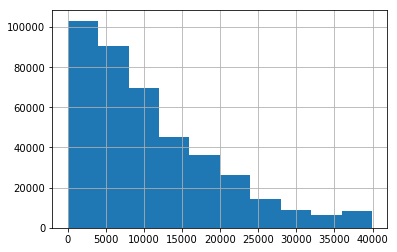

In [119]:
threshold = 40000
train_df_new[train_df_new['home_to_work_dist'] < threshold]['home_to_work_dist'].hist();

print("размер train_df_new: {0}, с учетом threshold по расстоянию: {1} ({2}) ".format(
    len(train_df_new), 
    len(train_df_new[train_df_new['home_to_work_dist'] < threshold]), 
    round((len(train_df_new[train_df_new['home_to_work_dist'] < threshold]))/len(train_df_new),2)))

In [120]:
"""запоминаем новый train"""
train_df_new = train_df_new[train_df_new['home_to_work_dist'] < threshold].copy()

In [ ]:
"""добавлем фильтр для тех ID, у которых дом и работа находятся далеко от транзакций"""

In [318]:
train_df.customer_id.nunique()

3732

In [ ]:
"""в классификации этот блок пропускаем"""

In [107]:
"""растояние до дома: создаем целевую переменную для моделирования / функция для расчета дистанции ниже"""
y_home_distance = []

for i, row in tqdm_notebook(enumerate(train_df[['home_add_lat', 'home_add_lon', 'address_lat', 'address_lon']].itertuples())):
    y_home_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))

In [115]:
"""растояние до работы: создаем целевую переменную для моделирования / функция для расчета дистанции ниже"""
y_work_distance = []

for i, row in tqdm_notebook(enumerate(train_df[['work_add_lat', 'work_add_lon', 'address_lat', 'address_lon']].itertuples())):
    y_work_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))

In [109]:
y_df = train_df[['home_add_lat', 'home_add_lon' ,'work_add_lat', 'work_add_lon']].copy()
y_df['y_home_distance'] = y_home_distance
y_df['y_work_distance'] = y_work_distance

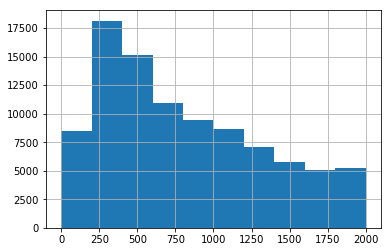

In [110]:
y_df[y_df['y_home_distance'] < 2000]['y_home_distance'].hist();

In [7]:
y = np.log1p(train_df['y_home_dist'])

In [8]:
len(train_df), len(y)

(705366, 705366)

In [123]:
train.columns[:80]

Index(['address_lat', 'address_lon', 'amount', 'currency', 'mcc', 'tr_type',
       'country', 'region', 'place', 'frq_rg', 'frq_pl', 'am_e', 'am_10',
       'am_10_sum', 'am_10_mean', 'am_10_amax', 'am_10_amin', 'am_10_median',
       'am_10_size', 'am_10_std', 'am_10_var', 'month', 'week', 'day', 'dow',
       'winm', 'is_wkend', '23feb', '8mar', '1may', '9may', '12jun', '4nov',
       '24feb', '8may', 'tr_qty_time', 'time_diff', 'date_reg_count',
       'date_reg_uni', 'frq_date', 'id_gps_count', 'cum_neighb_dist',
       'neighb_count', 'irs_description', 'is_dr', 'frq_mcc', 'amr_sum',
       'amr_mean', 'amr_median', 'amr_size', 'amr_std', 'amr_var', 'amp_sum',
       'amp_mean', 'amp_median', 'amp_size', 'amp_std', 'amp_var', 'ammc_sum',
       'ammc_mean', 'ammc_median', 'ammc_size', 'ammc_std', 'ammc_var',
       'amd_sum', 'amd_mean', 'amd_median', 'amd_size', 'amd_std', 'amd_var',
       'am_ireg_sum', 'am_ireg_mean', 'am_ireg_amax', 'am_ireg_amin',
       'am_ireg_median', '

In [9]:
train = train_df.drop(['customer_id', 'terminal_id', 'transaction_date', 'gps', 'test_sample', 'clusters',
              'nearby_home', 'nearby_work',
                      'work_add_lat', 'work_add_lon', 'home_add_lat', 'home_add_lon',
                      'y_home_dist'],axis=1)

In [10]:
test = test.drop(['customer_id', 'terminal_id', 'transaction_date', 'gps', 'test_sample', 'clusters',
                 'nearby_home', 'nearby_work',
                 'work_add_lat', 'work_add_lon', 'home_add_lat', 'home_add_lon',
                      'y_home_dist'], axis=1)

In [11]:
"""добавляем факторы расстояния"""
train['ttl_count'] = train["id_gps_count"] + train["neighb_count"]
train['av_dist'] = train['cum_neighb_dist'] / train['neighb_count']

test['ttl_count'] = test["id_gps_count"] + test["neighb_count"]
test['av_dist'] = test['cum_neighb_dist'] / test['neighb_count']

"""факторы с latlon"""
train['latlon_sum'] = train["address_lat"] + train["address_lon"]
train['latlon_mult'] = train["address_lat"] * train["address_lon"]

test['latlon_sum'] = test["address_lat"] + test["address_lon"]
test['latlon_mult'] = test["address_lat"] * test["address_lon"]

In [12]:
"""новые признаки"""
train['lat_sq'] = train['address_lat'] ** 2
train['lon_sq'] = train['address_lon'] ** 2
test['lat_sq'] = test['address_lat'] ** 2
test['lon_sq'] = test['address_lon'] ** 2

train['amount_sq'] = train['amount'] ** 2
test['amount_sq'] = test['amount'] ** 2

train['ball_share'] = train['ttl_count'] / train['am_10_size']
test['ball_share'] = test['ttl_count'] / test['am_10_size']

train['ln_av_dist'] = np.log1p(train['av_dist'])
test['ln_av_dist'] = np.log1p(test['av_dist'])

train['sq_av_dist'] = train['av_dist'] ** 2
test['sq_av_dist'] = test['av_dist'] ** 2

In [13]:
"""признаки с центроидом // отклонение от медианы"""
train['centr_lat_dev'] = train['address_lat_cl_median'] - train['address_lat']
train['centr_lon_dev'] = train['address_lon_cl_median'] - train['address_lon']

test['centr_lat_dev'] = test['address_lat_cl_median'] - test['address_lat']
test['centr_lon_dev'] = test['address_lon_cl_median'] - test['address_lon']

In [14]:
train[['sml_mc_h_dist_ln', 'sml_pl_h_dist_ln', 'sml_dow_h_dist_ln']] = np.log1p(train[
    ['sml_mc_h_dist', 'sml_pl_h_dist', 'sml_dow_h_dist']])

test[['sml_mc_h_dist_ln', 'sml_pl_h_dist_ln', 'sml_dow_h_dist_ln']] = np.log1p(test[
    ['sml_mc_h_dist', 'sml_pl_h_dist', 'sml_dow_h_dist']])

In [15]:
"""убираем NA"""
train = train.fillna(0)
test = test.fillna(0)

In [16]:
print(len(train.columns), len(test.columns)), len(train)

157 157


(None, 705366)

In [ ]:
"""UNNAMED убрать !!! """

In [19]:
train.to_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_train.csv')
test.to_csv(r'C...\\
data\train and test for modeling\2018_03_20_home_regression_test.csv')

In [20]:
pd.Series(y).to_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_train_y.csv')

In [5]:
train = pd.read_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_train.csv')
test = pd.read_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_test.csv')
y = pd.read_csv(r'...\\
data\train and test for modeling\2018_03_20_home_regression_train_y.csv', names='y')

In [9]:
train.drop(train.columns[:2], axis=1, inplace=True)
test.drop(test.columns[:2], axis=1, inplace=True)

In [21]:
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, log_loss

#https://github.com/Yorko/mlcourse_open/tree/master/jupyter_russian/topic10_boosting

import xgboost as xgb

In [22]:
#https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [23]:
"""переводим в формат float32"""
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
        
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=17)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [25]:
def score(params):
    from sklearn.metrics import r2_score
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 1))
    score = -r2_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [26]:
def optimize(trials):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.01, 0.1, 0.01),
             'max_depth': hp.quniform('max_depth', 5, 15, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [136]:
%%time
"""поиск набора гиперпараметров"""
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0.81, 'learning_rate': 0.04, 'max_depth': 5.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.5}
	Score -0.5247365404223174


Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0.87, 'learning_rate': 0.04, 'max_depth': 14.0, 'min_child_weight': 4.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6000000000000001}
	Score -0.9267598168431694


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'rmse', 'gamma': 0.81, 'learning_rate': 0.09, 'max_depth': 9.0, 'min_child_weight': 8.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.55}
	Score -0.8329932697966057


Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'rmse', 'gamma': 0.89, 'learning_rate': 0.06, 'max_depth': 9.0, 'min_child_we

In [27]:
best_params = {'colsample_bytree': 0.8,
 'eta': 0.04,
 'gamma': 0.87,
 'max_depth': 14.0,
 'min_child_weight': 4.0,
 'subsample': 0.6000000000000001}

In [137]:
best_params

{'colsample_bytree': 0.8,
 'eta': 0.04,
 'gamma': 0.87,
 'max_depth': 14.0,
 'min_child_weight': 4.0,
 'subsample': 0.6000000000000001}

In [28]:
"""устанавливаем параметры для модели"""
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'rmse'
best_params['objective'] = 'reg:linear'
best_params['nthread'] = 4
best_params['silent'] = 1

In [29]:
"""тренируем модель на всех данных трейна"""
dtrain = xgb.DMatrix(train, y)

In [136]:
%%time
"""кросс-валидация"""
xgbCvResult = xgb.cv(best_params, dtrain, 
                      num_boost_round=500,  
                      nfold=3, early_stopping_rounds=50)

Wall time: 11min 19s


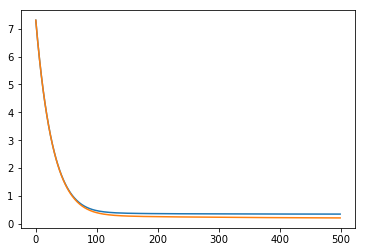

In [137]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['test-merror-mean'])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['train-merror-mean']);

In [138]:
best_num_round = np.argmin(xgbCvResult['test-merror-mean'])
best_num_round

497

In [31]:
%%time
bestXgb = xgb.train(best_params, dtrain, num_boost_round=500)

Wall time: 32min 35s


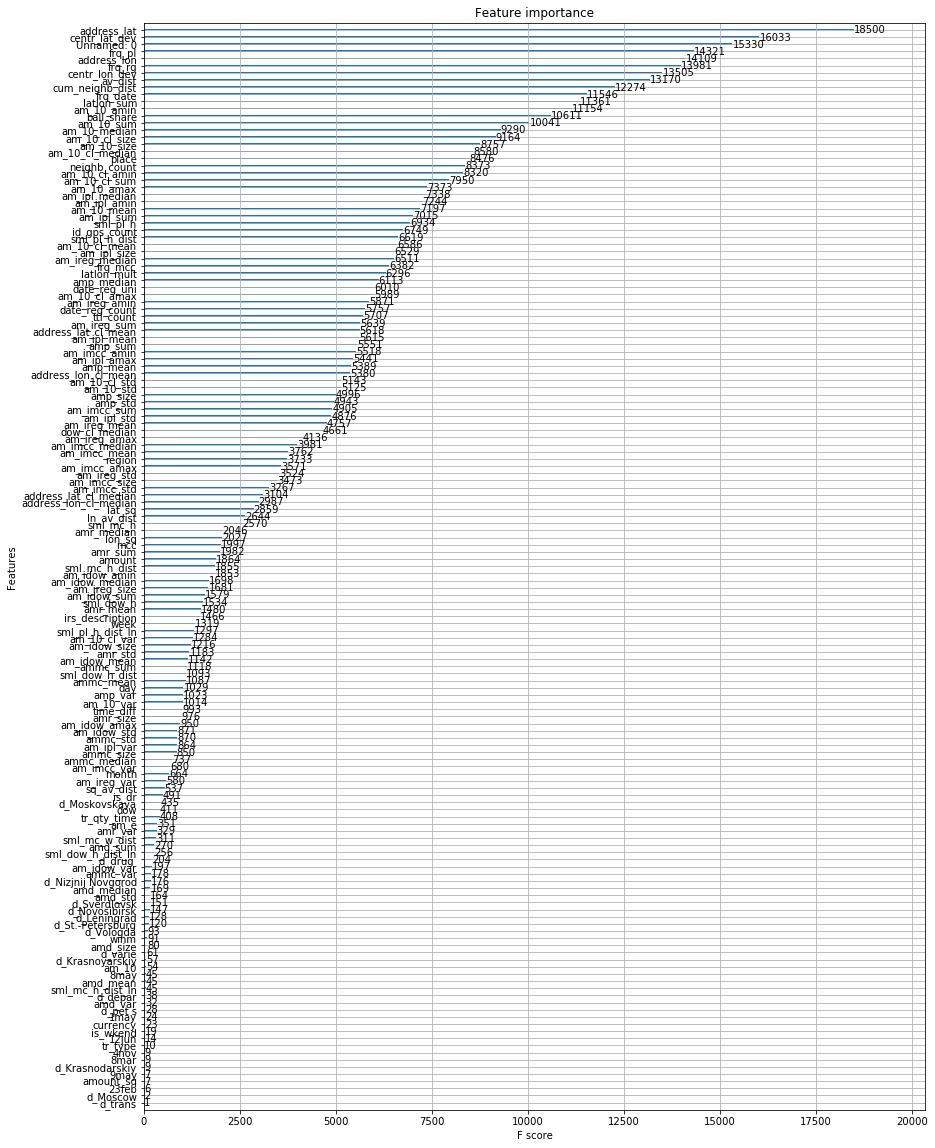

In [32]:
#важные факторы (сколько раз использовались для разбиения дерева)
fig, ax = plt.subplots(figsize=(14, 20))
xgb.plot_importance(bestXgb, ax=ax);

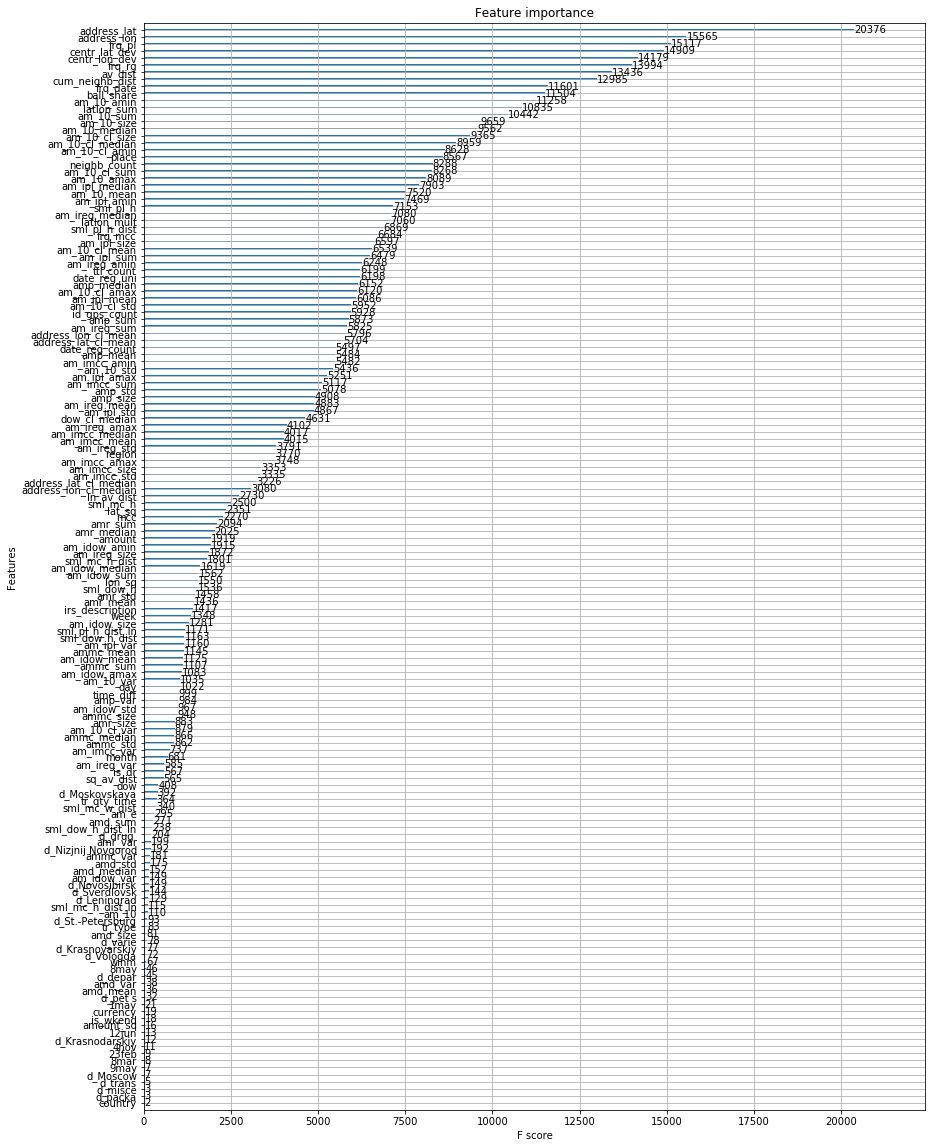

In [141]:
#важные факторы (сколько раз использовались для разбиения дерева)
fig, ax = plt.subplots(figsize=(14, 20))
xgb.plot_importance(bestXgb, ax=ax);

In [ ]:
import operator
importance = bestXgb.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
importance_df['fscr_share'] = importance_df['fscore'] / importance_df['fscore'].sum()

In [142]:
"""выводим табличку с результатами: факт и модель"""
train_results_table = pd.DataFrame(np.expm1(bestXgb.predict(dtrain)))
train_results_table['y'] = np.expm1(y)

In [ ]:
"""строим табличку с результатами для локальной валидации"""

In [144]:
train_results_table['ttl_count'] = train['ttl_count'].reset_index(drop=True)
#train_results_table['prob_1'] = train_results_table[1] * train_results_table['ttl_count']
#train_results_table['prob_0'] = train_results_table[0] * train_results_table['ttl_count']
train_results_table['address_lat'] = train['address_lat'].reset_index(drop=True)
train_results_table['address_lon'] = train['address_lon'].reset_index(drop=True)
train_results_table['customer_id'] = train_df.customer_id.reset_index(drop=True)
#train_results_table['y_pred'] = y_pred

In [146]:
train_results_table.head()

,0,y,ttl_count,address_lat,address_lon,customer_id,clusters
0,2843.996582,3050.360988,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0
1,2893.324951,3050.360988,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0
2,1216.813232,817.503311,17.0,59.858200,30.229023,0dc0137d280a2a82d2dc89282450ff1b,1
3,2847.316895,3050.360988,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0
4,2881.240967,3050.360988,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0


In [145]:
train_results_table['clusters'] = train_and_test_together[
    train_and_test_together.test_sample!=1]['clusters'].reset_index(drop=True).copy()

In [148]:
train_results_table = pd.merge(train_results_table, real_address, on='customer_id', how='left')

In [149]:
train_results_table.to_csv(r'...\\
mod results\2018_03_19_home_xgb_regression_train.csv')

In [293]:
work_answer_train = train_results_table[train_results_table.groupby(
['customer_id'])[1].transform(max) == train_results_table[1] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [288]:
work_answer_train.columns = ['customer_id', 'work_add_lat_p','work_add_lon_p']

In [294]:
validation_table = pd.merge(work_answer_train[work_answer_train.customer_id.isin(
    list(real_address[real_address.work_add_lat.isnull() == 0]['customer_id'].unique()))==1], 
                            real_address[real_address.work_add_lat.isnull() == 0], 
                            on='customer_id', how='left')

In [178]:
%%time
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088                        # define the number of kilometers in one radian
epsilon = 2 / kms_per_radian                      # define epsilon as 3 kilometers, converted to radians for use by haversine

train_results_table['DBSCAN'] = 0

for cust in tqdm_notebook(list(train_results_table.customer_id.unique())):
    
    coords = train_results_table[train_results_table.customer_id == cust][['address_lat', 'address_lon']].as_matrix() 
    index = train_results_table[train_results_table.customer_id == cust].index
    
    if len(coords) <= 15:
        min_sample = 2
    else:
        min_sample = round(len(coords)/10,0)
    
    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    train_results_table.loc[index,'DBSCAN'] = db.labels_


Wall time: 3min 38s


In [179]:
work_train_answer_keys = train_results_table[train_results_table.groupby(['customer_id'])[1].transform(max) == 
                               train_results_table[1]].drop_duplicates('customer_id')

In [180]:
%%time
"""выбераем макс веротности по кластерам, делаем небольшое смещение: среднее по 3-ем точкам"""
work_train_answer_dict = {}

for cust in tqdm_notebook(list(work_train_answer_keys.customer_id)):
    cluster = work_train_answer_keys.loc[work_train_answer_keys[work_train_answer_keys.customer_id==cust].index[0],'DBSCAN']
    index = train_results_table[train_results_table.customer_id==cust].index
    df_ = train_results_table.loc[index,['address_lat', 'address_lon', 'DBSCAN', 1]]
    df_ = df_[df_['DBSCAN'] == cluster] 
    
    if (cluster == -1) | (len(df_) < 3) :
        work_train_answer_dict[cust] = [df_.loc[df_[1].nlargest(1).index,'address_lat'].item(),
                                  df_.loc[df_[1].nlargest(1).index,'address_lon'].item()]
    else:
        work_train_answer_dict[cust] = [df_.loc[df_[1].nlargest(3).index,'address_lat'].mean(), 
                                  df_.loc[df_[1].nlargest(3).index,'address_lon'].mean()]


Wall time: 1min 58s


In [184]:
"""DBSCAN"""
"""с dbscan хуже (3km), такой же(2km)"""
work_train_answer_dbscan = pd.DataFrame(work_train_answer_dict).T.reset_index()
work_train_answer_dbscan.columns = ['customer_id', 'work_add_lat_p_dbscan', 'work_add_lon_p_dbscan']
validation_table = pd.merge(validation_table, work_train_answer_dbscan, on='customer_id', how='left')
validation_table['work_add_lat_p'] = validation_table['work_add_lat_p_dbscan']
validation_table['work_add_lon_p'] = validation_table['work_add_lon_p_dbscan']

In [433]:
"""подход с фильтрацией вер-ти"""
"""устанавливаем порог для вер-ти"""
treshold = 0.95
work_train_answer_prob = train_results_table[train_results_table[1] >= treshold].groupby('customer_id')[
    ['address_lat', 'address_lon']].mean().reset_index()
validation_table = pd.merge(validation_table, work_train_answer_prob, on='customer_id', how='left')


"""заполняем пропуски, т.к. не у все ID вер-ть выше порога"""
validation_table['address_lat_y'] = validation_table['address_lat_y'].fillna(validation_table['work_add_lat'])
validation_table['address_lon_y'] = validation_table['address_lon_y'].fillna(validation_table['work_add_lon'])

validation_table['work_add_lat_p'] = validation_table['address_lat_y']
validation_table['work_add_lon_p'] = validation_table['address_lon_y']

In [231]:
"""значительное увеличение метрики на трейне"""

In [ ]:
"""рассчитываем метрику с радиусом"""

In [290]:
"""WORK"""
np.where((np.sqrt(((validation_table.work_add_lat_p - validation_table.work_add_lat) ** 2) + 
        ((validation_table.work_add_lon_p - validation_table.work_add_lon) ** 2)) <= RADIUS), 1, 0).sum() / len(validation_table)

0.4947654129507561

In [132]:
"""HOME"""
np.where((np.sqrt(((validation_table.home_add_lat_p - validation_table.home_add_lat) ** 2) + 
        ((validation_table.home_add_lon_p - validation_table.home_add_lon) ** 2)) <= RADIUS), 1, 0).sum() / len(validation_table)

0.91284547738693467

In [300]:
%%time
work_tresholds_dic = {}

for steps in np.arange(0.02,0.98, 0.02):


    validation_table = pd.merge(work_answer_train[work_answer_train.customer_id.isin(
    list(real_address[real_address.work_add_lat.isnull() == 0]['customer_id'].unique()))==1], 
                            real_address[real_address.work_add_lat.isnull() == 0], 
                            on='customer_id', how='left')

    """подход с фильтрацией вер-ти"""
    """устанавливаем порог для вер-ти"""
    treshold = steps
    work_train_answer_prob = train_results_table[train_results_table[1] >= treshold].groupby('customer_id')[
        ['address_lat', 'address_lon']].mean().reset_index()
    validation_table = pd.merge(validation_table, work_train_answer_prob, on='customer_id', how='left')


    """заполняем пропуски, т.к. не у все ID вер-ть выше порога"""
    validation_table['address_lat_y'] = validation_table['address_lat_y'].fillna(validation_table['address_lat_x'])
    validation_table['address_lon_y'] = validation_table['address_lon_y'].fillna(validation_table['address_lon_x'])

    validation_table['work_add_lat_p'] = validation_table['address_lat_y']
    validation_table['work_add_lon_p'] = validation_table['address_lon_y']

    """WORK"""
    work_tresholds_dic[steps] = np.where((np.sqrt(((validation_table.work_add_lat_p - validation_table.work_add_lat) ** 2) + 
            ((validation_table.work_add_lon_p - 
              validation_table.work_add_lon) ** 2)) <= RADIUS), 1, 0).sum() / len(validation_table)

Wall time: 1.75 s


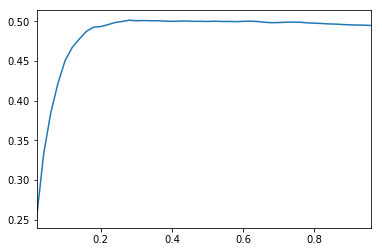

In [301]:
pd.Series(work_tresholds_dic).plot();

In [550]:
pd.Series(work_tresholds_dic).argmax()

0.34000000000000002

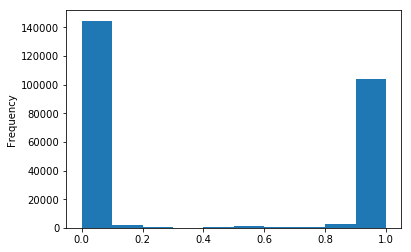

In [569]:
train_results_table[1].plot.hist()

In [302]:
"""добавляем результат (1 или 0) в таблицу"""
validation_table['work_answer'] = np.where((np.sqrt(((validation_table.work_add_lat_p - validation_table.work_add_lat) ** 2) + 
        ((validation_table.work_add_lon_p - validation_table.work_add_lon) ** 2)) <= RADIUS), 1, 0)
#validation_table['home_answer'] = np.where((np.sqrt(((validation_table.home_add_lat_p - validation_table.home_add_lat) ** 2) + 
#        ((validation_table.home_add_lon_p - validation_table.home_add_lon) ** 2)) <= RADIUS), 1, 0)

In [ ]:
"""анализируем получившиеся реузльаты/ошибку"""

In [165]:
print(validation_table[validation_table.work_answer==0]['home_answer'].sum()/
 len(validation_table[validation_table.work_answer==0]['home_answer']))

print(validation_table[validation_table.home_answer==0]['work_answer'].sum()/
 len(validation_table[validation_table.home_answer==0]['work_answer']))

0.628440366972
0.581755593804


In [303]:
validation_table['work_score'] = (np.sqrt(((validation_table.work_add_lat_p - validation_table.work_add_lat) ** 2) + 
        ((validation_table.work_add_lon_p - validation_table.work_add_lon) ** 2)))
#validation_table['home_score'] = (np.sqrt(((validation_table.home_add_lat_p - validation_table.home_add_lat) ** 2) + 
#        ((validation_table.home_add_lon_p - validation_table.home_add_lon) ** 2)))

In [304]:
validation_table[validation_table.work_answer==0]['customer_id'][10:20]

15    5ddef25d2fd7bc42b794ccbf364bae3f
16    69ec92af42dd2c771f73008893c356d0
19    a89fca446f4c5dcf68820f22d4a5d424
20    b0535ffedfd0679c7edd0ec137929dd5
21    c21dc6277f05c7a6387ce21fb88a16d5
22    f3dc8ff7f2ca28147dfde8de1e8fa1c1
23    fd39bb8d9328e9001b748068fbd3e39b
24    01a3f2fe4b53e557118811af184e9922
26    1c749bd5e88406d4441440b858793823
28    3bae2f725ee822e0775d9557a4a25441
Name: customer_id, dtype: object

In [337]:
idn = '01a3f2fe4b53e557118811af184e9922'

coords = train_results_table[train_results_table.customer_id==idn][['address_lat','address_lon', 
                                                                                   1, 'y_pred']].copy()

latlon_pred = validation_table[validation_table.customer_id==idn][['work_add_lat_p', 'work_add_lon_p']]

latlon_fact = validation_table[validation_table.customer_id==idn][['work_add_lat', 'work_add_lon']]

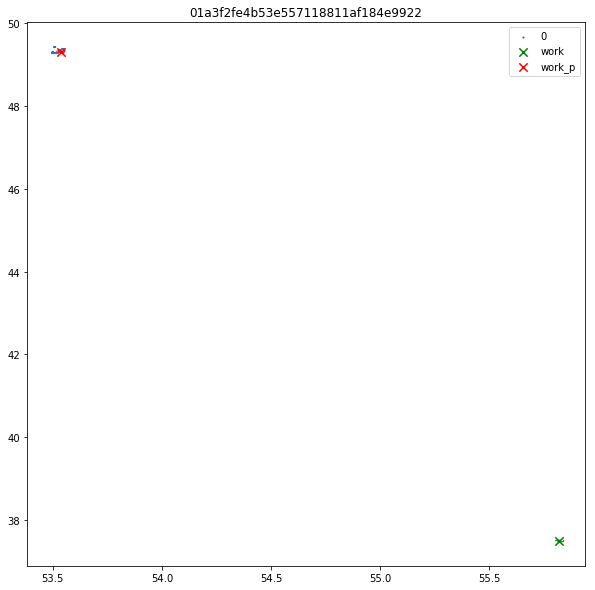

In [338]:
y, x = coords.address_lat, coords.address_lon
labels = coords.y_pred
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

circle1 = plt.Circle((latlon_fact.values[0,0], latlon_fact.values[0,1]), 0.02, fill=False, color='g', ls='--');
#circle2 = plt.Circle((latlon_fact.values[0,2], latlon_fact.values[0,3]), 0.02, fill=False, color='g', ls='--');
circle3 = plt.Circle((latlon_pred.values[0,0], latlon_pred.values[0,1]), 0.02, fill=False, color='r', ls='--');
#circle4 = plt.Circle((latlon_pred.values[0,2], latlon_pred.values[0,3]), 0.02, fill=False, color='r', ls='--');

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group.y, group.x, s=coords[1]*100,marker='o', label=name)

plt.scatter(latlon_fact.values[0,0], latlon_fact.values[0,1], s=70, marker='x', color='g', label='work');
#plt.scatter(latlon_fact.values[0,2], latlon_fact.values[0,3], s=70, marker='v', color='g', label='home');
plt.scatter(latlon_pred.values[0,0], latlon_pred.values[0,1], s=70, marker='x', color='r', label='work_p');
#plt.scatter(latlon_pred.values[0,2], latlon_pred.values[0,3], s=70, marker='v', color='r', label='home_p');


ax.legend()

ax.add_artist(circle1)
#ax.add_artist(circle2)
ax.add_artist(circle3)
#ax.add_artist(circle4)

plt.title(idn)
#plt.ylim(50.7,51.0)
#plt.xlim(61.0,61.8)
plt.show()

In [ ]:
"""делаем прогноз для теста"""

In [30]:
dtestX = xgb.DMatrix(test)

In [32]:
%%time
xgboost_predict_proba = bestXgb.predict(dtestX)

Wall time: 35.9 s


In [35]:
pd.Series(np.expm1(xgboost_predict_proba)).to_csv(r'...\mod results\2018_03_20_home_xgb_regression_test_y.csv')

In [38]:
sub_results = test[['address_lat', 'address_lon', 'ttl_count']].reset_index(drop=True).copy()
sub_results['customer_id'] = train_and_test_together[train_and_test_together['test_sample']==1]['customer_id'].reset_index(
    drop=True)
sub_results = sub_results.reset_index().join(pd.DataFrame(xgboost_predict_proba))
sub_results['clusters'] = train_and_test_together[
    train_and_test_together.test_sample==1]['clusters'].reset_index(drop=True).copy()

In [41]:
sub_results[0] = np.expm1(xgboost_predict_proba)

In [42]:
sub_results.head()

,index,address_lat,address_lon,ttl_count,customer_id,0,clusters
0,0,55.967487,37.913681,21.0,00fd410f5c580c8351cafa88d82b60f3,712.150574,0
1,1,55.971294,37.905186,13.0,00fd410f5c580c8351cafa88d82b60f3,843.885437,0
2,2,56.016590,37.909100,4.0,00fd410f5c580c8351cafa88d82b60f3,15918.387695,1
3,3,55.964508,37.937912,2.0,00fd410f5c580c8351cafa88d82b60f3,1924.339600,0
4,4,55.776802,37.657352,3.0,00fd410f5c580c8351cafa88d82b60f3,41635.761719,-1


In [43]:
sub_results.to_csv(r'...\\
mod results\2018_03_20_home_xgb_regression_test.csv')

In [274]:
work_answer = sub_results[sub_results.groupby(
['customer_id'])['dist_prob'].transform(max) == sub_results['dist_prob'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [275]:
len(work_answer)

9997

In [276]:
submission = data['sub'].copy()
submission.drop(['work_add_lat', 'work_add_lon', 'home_add_lat','home_add_lon'], axis=1, inplace=True)

In [277]:
submission = pd.merge(submission, work_answer, on='customer_id', how='left')

In [278]:
"""подход с фильтрацией вер-ти"""
"""устанавливаем порог для вер-ти"""
treshold = 0.45
work_answer_prob = sub_results[sub_results['cl_1'] >= treshold].groupby('customer_id')[
    ['address_lat', 'address_lon']].mean().reset_index()
submission = pd.merge(submission, work_answer_prob, on='customer_id', how='left')
submission = pd.merge(submission, work_answer, on='customer_id', how='left')

"""заполняем пропуски, т.к. не у все ID вер-ть выше порога"""
submission['address_lat_x'] = submission['address_lat_x'].fillna(submission['address_lat_y'])
submission['address_lon_x'] = submission['address_lon_x'].fillna(submission['address_lon_y'])

submission['address_lat_y'] = 0
submission['address_lon_y'] = 0

In [280]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [278]:
"""скрещиваем с 20-ым сабом"""
sub20 = pd.read_csv(r'...\sub23h.csv')
sub20.set_index('_ID_', inplace=True)

In [281]:
submission['_HOME_LAT_'] = sub20['_HOME_LAT_']
submission['_HOME_LON_'] = sub20['_HOME_LON_']

In [284]:
submission.to_csv(r'...\subs\sub24.csv')

In [283]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9997 entries, 00021683ccb416637fe9a4cd35e4606e to ffebf4ea02c72183128d966721976ec9
Data columns (total 4 columns):
_WORK_LAT_    9997 non-null float32
_WORK_LON_    9997 non-null float32
_HOME_LAT_    9997 non-null float64
_HOME_LON_    9997 non-null float64
dtypes: float32(2), float64(2)
memory usage: 312.4+ KB


In [286]:
train_results_table.to_csv(r'...\mod results\2018_03_07_xgb_im_work_regres_train.csv')

In [285]:
sub_results.to_csv(r'...\mod results\2018_03_07_xgb_im_work_regres_test.csv')

In [155]:
%%time
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088                        # define the number of kilometers in one radian
epsilon = 3 / kms_per_radian                      # define epsilon as 3 kilometers, converted to radians for use by haversine

sub_results['DBSCAN'] = 0

for cust in tqdm_notebook(list(sub_results.customer_id.unique())):
    
    coords = sub_results[sub_results.customer_id == cust][['address_lat', 'address_lon']].as_matrix() 
    index = sub_results[sub_results.customer_id == cust].index
    
    if len(coords) <= 15:
        min_sample = 2
    else:
        min_sample = round(len(coords)/10,0)
    
    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    sub_results.loc[index,'DBSCAN'] = db.labels_


Wall time: 26min 22s


In [161]:
sub_results['DBSCAN_max'] = sub_results.groupby(['customer_id', 'DBSCAN'])['cl_1'].transform(np.max)

In [172]:
home_answer_keys = sub_results.groupby('customer_id')[['DBSCAN_max', 'DBSCAN']].max()

In [173]:
%%time
"""выбераем макс веротности по кластерам, делаем небольшое смещение: среднее по 3-ем точкам"""
home_answer_dict = {}

for cust in tqdm_notebook(list(home_answer_keys.index)):
    cluster = home_answer_keys.loc[cust,:][1].astype(int)
    index = sub_results[sub_results.customer_id==cust].index
    df_ = sub_results.loc[index,['address_lat', 'address_lon', 'DBSCAN', 'cl_1']]
    df_ = df_[df_['DBSCAN'] == cluster] 
    
    if (cluster == -1) | (len(df_) < 3) :
        index_ = df_['cl_1'].argmax()
        home_answer_dict[cust] = list(df_.loc[index_, ['address_lat', 'address_lon'] ].values)
    else:
        lat_3poi = ((df_.loc[list(df_['cl_1'].argsort()[-3:].index)[2], ['address_lat', 'address_lon']].values[0] + 
                     df_.loc[list(df_['cl_1'].argsort()[-3:].index)[1], ['address_lat', 'address_lon']].values[0] + 
                     df_.loc[list(df_['cl_1'].argsort()[-3:].index)[0], ['address_lat', 'address_lon']].values[0]) / 3)
        lon_3poi = ((df_.loc[list(df_['cl_1'].argsort()[-3:].index)[2], ['address_lat', 'address_lon']].values[1] + 
                     df_.loc[list(df_['cl_1'].argsort()[-3:].index)[1], ['address_lat', 'address_lon']].values[1] + 
                     df_.loc[list(df_['cl_1'].argsort()[-3:].index)[0], ['address_lat', 'address_lon']].values[1]) / 3)
        
        home_answer_dict[cust] = [lat_3poi, lon_3poi]


Wall time: 14min 31s


In [174]:
home_answer = pd.DataFrame(home_answer_dict).T

In [175]:
home_answer.reset_index(inplace=True)
home_answer.columns = ['customer_id', 'wlat', 'wlon']

In [179]:
submission = pd.merge(submission, home_answer, on='customer_id', how='left')

In [180]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [182]:
submission.to_csv(r'...\subs\sub18.csv')

In [195]:
sub_results['prob_1'] = sub_results['cl_1'] * sub_results['ttl_count']
sub_results['prob_2'] = sub_results['cl_2'] * sub_results['ttl_count']

In [ ]:
""" СДЕЛАТЬ С CL_1 & CL_2 """

In [249]:
home_answer = sub_results[sub_results.groupby(
['customer_id'])['cl_1'].transform(max) == sub_results['cl_1'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [250]:
work_answer = sub_results[sub_results.groupby(
['customer_id'])['cl_2'].transform(max) == sub_results['cl_2'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [642]:
"""(II) approach"""

treshold1 = 0.40
treshold2 = 0.40
treshold3 = 0.40

high_prob_work =  sub_results[(sub_results['cl_2'] > treshold2)]
high_prob_home = sub_results[(sub_results['cl_1'] > treshold1)]
high_prob_wh = sub_results[(sub_results['cl_3'] > treshold3)]

In [643]:
home_answer = high_prob_home[high_prob_home.groupby(
['customer_id'])['cl_1'].transform(max) == high_prob_home['cl_1'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [644]:
work_answer = high_prob_work[high_prob_work.groupby(
['customer_id'])['cl_2'].transform(max) == high_prob_work['cl_2'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [645]:
submission = data['sub'].copy()
submission.drop(['work_add_lat', 'work_add_lon', 'home_add_lat','home_add_lon'], axis=1, inplace=True)
submission = pd.merge(submission, work_answer, on='customer_id', how='left')
submission = pd.merge(submission, home_answer, on='customer_id', how='left')
submission.columns = ['customer_id', 'work_add_lat_p', 'work_add_lon_p', 'home_add_lat_p','home_add_lon_p']

In [646]:
home_answer = high_prob_wh[high_prob_wh.groupby(
['customer_id'])['cl_3'].transform(max) == high_prob_wh['cl_3'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]
work_answer = high_prob_wh[high_prob_wh.groupby(
['customer_id'])['cl_3'].transform(max) == high_prob_wh['cl_3'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon']]

In [647]:
submission = pd.merge(submission, work_answer, on='customer_id', how='left')
submission = pd.merge(submission, home_answer, on='customer_id', how='left')

In [648]:
submission['work_add_lat_p'] = submission['work_add_lat_p'].fillna(submission.address_lat_x)
submission['work_add_lon_p'] = submission['work_add_lon_p'].fillna(submission.address_lon_x)
submission['home_add_lat_p'] = submission['home_add_lat_p'].fillna(submission.address_lat_y)
submission['home_add_lon_p'] = submission['home_add_lon_p'].fillna(submission.address_lon_y)

In [649]:
submission.drop(list(submission.columns[5:]), axis=1, inplace=True)

In [656]:
sub10 = pd.read_csv(r'...\subs\sub10.csv')

In [650]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']

In [651]:
for col in list(submission.columns)[1:]:
    submission[col] = submission[col].fillna(sub11[col])

In [658]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [660]:
submission.head()

,_WORK_LAT_,_WORK_LON_,_HOME_LAT_,_HOME_LON_
_ID_,,,,
00021683ccb416637fe9a4cd35e4606e,0.0,0.0,55.038212,82.977364
0002d0f8a642272b41c292c12ab6e602,0.0,0.0,44.028999,42.841000
0004d182d9fede3ba2534b2d5e5ad27e,0.0,0.0,43.597000,39.727001
0008c2445518c9392cb356c5c3db3392,0.0,0.0,51.529018,46.029404
000b373cc4969c0be8e0933c08da67e1,0.0,0.0,56.237175,43.463005


In [661]:
submission.to_csv(r'...\subs\sub14.csv')

In [659]:
submission[['_WORK_LAT_']] = 0
submission[['_WORK_LON_']] = 0

In [657]:
submission = sub10

In [252]:
submission = pd.merge(submission, work_answer, on='customer_id', how='left')
submission = pd.merge(submission, home_answer, on='customer_id', how='left')

In [253]:
len(home_answer), len(work_answer)

(9997, 9997)

In [254]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [664]:
sub_results.to_excel(r'...\data\2018_03_02_sub_results.xlsx')

In [226]:
sub_results.to_csv('2018_02_26_sub_results.csv')

In [350]:
sub_results.customer_id.value_counts()[100:110]

c0f276f4e7400587a98086eb4d373fdc    418
e7d70df45e92b6837713cbeb0a8ed8fb    417
71da3dfac9d864a8ab8a32c8ed07238f    417
7d8271f339e2fb1fadd40b4b1d900bd0    416
9b73f7f2a07a977e2b3add8e86787272    416
3ff2ae87afdaacd41cfde4157c648421    412
11f8d62c3b837d11f28a624efcee06ab    408
24c6844f369dfdf3b5ed09ae6a44d504    407
ebcc25347e38d684c38cb33f97f9b9ff    406
a07c1faa182754ea0164b51ba35b2913    405
Name: customer_id, dtype: int64

In [150]:
idn = '00021683ccb416637fe9a4cd35e4606e'

coords = sub_results[sub_results.customer_id==idn][['address_lat','address_lon', 
                                                                                   'cl_1', 'cl_2', 'cl_3', 'y_pred',
                                                                                  'prob_1', 'prob_2']].copy()

#latlon_pred = np.array(submission[submission.index==idn])

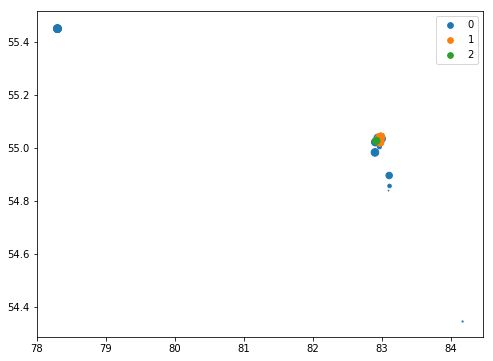

In [151]:
y, x = coords.address_lat, coords.address_lon
labels = coords.y_pred
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

#circle3 = plt.Circle((latlon_pred[0,0], latlon_pred[0,1]), 0.02, fill=False, color='r', ls='--');
#circle4 = plt.Circle((latlon_pred[0,2], latlon_pred[0,3]), 0.02, fill=False, color='r', ls='--');

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group.x, group.y, s=coords.cl_1*100, marker='o', label=name)

#plt.scatter(latlon_pred[0,0], latlon_pred[0,1], s=70, marker='x', color='r', label='work_p');
#plt.scatter(latlon_pred[0,2], latlon_pred[0,3], s=70, marker='v', color='r', label='home_p');    

ax.legend()

#ax.add_artist(circle3)
#ax.add_artist(circle4)
plt.show()

In [ ]:
"""sub03: первый (работа) и последний (дом) """

In [375]:
first_and_last_home = df_for_Vanya[['customer_id', 'address_lat', 'address_lon']].iloc[1::2,:]
first_and_last_home.columns = ['customer_id', 'home_lat', 'home_lon']

In [376]:
first_and_last_work = df_for_Vanya[['customer_id', 'address_lat', 'address_lon']].iloc[::2,:]
first_and_last_work.columns = ['customer_id', 'work_lat', 'work_lon']

In [200]:
submission = data['sub'].copy()
submission.drop(['work_add_lat', 'work_add_lon', 'home_add_lat','home_add_lon'], axis=1, inplace=True)

In [378]:
submission = pd.merge(submission, first_and_last_work, on='customer_id', how='left')
submission = pd.merge(submission, first_and_last_home, on='customer_id', how='left')

In [288]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [291]:
submission.to_csv(r'...\subs\sub08.csv')

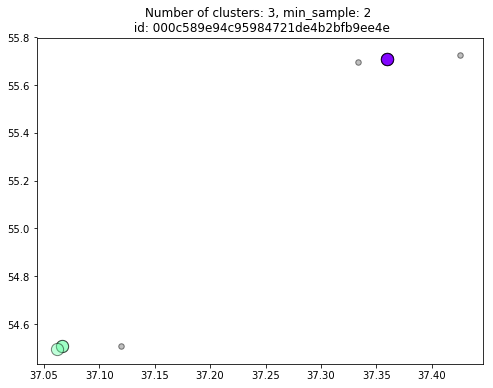

Wall time: 260 ms


In [135]:
%%time
# DBSCAN clustering
# represent points consistently as (lat, lon)
idn = '000c589e94c95984721de4b2bfb9ee4e'
coords = train_and_test_together[train_and_test_together.customer_id 
                        == idn][['address_lat', 'address_lon']].as_matrix()
kms_per_radian = 6371.0088        # define the number of kilometers in one radian
epsilon = 2 / kms_per_radian      # define epsilon as 3 kilometers, converted to radians for use by haversine

if len(coords) <= 15:
    min_sample = 2
else:
    min_sample = round(len(coords)/10,0)

db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 150
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Number of clusters: {0}, min_sample: {2} \n id: {1}'.format(num_clusters, idn, db.min_samples))
plt.show()

In [134]:
db.labels_

array([ 0,  1,  0,  0,  1, -1,  0,  1,  0,  0, -1], dtype=int64)